<a href="https://colab.research.google.com/github/abhistar/DDP_GAN/blob/main/GAN_style_transfer_DDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

%matplotlib inline

In [ ]:
manual_seed = 999
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Random Seed:  999


In [ ]:
# location of folder
dataroot = "drive/My Drive/new_images"
# number of workers
workers = 4
# batch size for training
batch_size = 30
# image size for input
image_size = 128
# number of channel (1 for BW, 3 for RGB)
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 16
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0005
# Beta values hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.99
# Number of GPUs available, currently running on CPU
ngpu = 1

print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [ ]:
# setup dataset and data loader
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(image_size), 
                                                                        transforms.CenterCrop(image_size),
                                                                        transforms.Grayscale(num_output_channels=3),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize((0.5,),(0.5,))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if(torch.cuda.is_available() and ngpu>0) else "cpu")

In [ ]:
# define weights for layer and normalisation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# define gram matrix for our tensor
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# define Styleloss for matrix
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# define content loss for matrix
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# importing VGG model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# normalise channels for vgg models
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input z into convolution
            nn.ConvTranspose2d(nz, ngf*8, 8, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            
            # state ngf * 8 * 8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            
            # state ngf/2 * 16*16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            
            # state ngf/4 * 32*32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state ngf/8 *64*64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            #state 1 *128*128            
        )
        
    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(16, 1024, kernel_size=(8, 8), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) *128*128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input is ndf/8 *64*64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            #input is ndf/4 *32*32
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            #input is ndf/2 *16*16
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            #input is ndf *8*8
            nn.Conv2d(ndf*8, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
alpha = 0.03

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # pass real and fake image to vgg model to obtain losses and new vgg model
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
        cnn_normalization_mean, cnn_normalization_std, real_cpu, fake.detach())

        model(fake.detach())

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Add gradient from style loss as well
        sum_loss = 0
        for sl in style_losses:
            sum_loss += sl.loss
        
        #calculate gradients on styleloss
        sum_loss.backward()
        
        errD = errD + alpha*sum_loss
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 60 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

  0%|          | 0/50 [00:00<?, ?it/s]

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0/50][0/182]	Loss_D: 2.6887	Loss_G: 89.8084	D(x): 0.8428	D(G(z)): 0.7189 / 0.0000
[0/50][60/182]	Loss_D: 0.9447	Loss_G: 21.1371	D(x): 1.0000	D(G(z)): 0.2585 / 0.1070
[0/50][120/182]	Loss_D: 100.0136	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/50][180/182]	Loss_D: 100.0137	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


  2%|▏         | 1/50 [11:38<9:30:44, 698.87s/it]

[1/50][0/182]	Loss_D: 100.0137	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/50][60/182]	Loss_D: 100.0138	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/50][120/182]	Loss_D: 100.0140	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/50][180/182]	Loss_D: 100.0139	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


  4%|▍         | 2/50 [16:11<7:36:52, 571.08s/it]

[2/50][0/182]	Loss_D: 100.0137	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/50][60/182]	Loss_D: 100.0135	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/50][120/182]	Loss_D: 100.0136	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/50][180/182]	Loss_D: 0.4631	Loss_G: 100.0000	D(x): 0.9667	D(G(z)): 0.0000 / 0.0000


  6%|▌         | 3/50 [20:44<6:17:18, 481.67s/it]

[3/50][0/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][60/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][180/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


  8%|▊         | 4/50 [25:17<5:21:16, 419.05s/it]

[4/50][0/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][60/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 10%|█         | 5/50 [29:50<4:41:24, 375.21s/it]

[5/50][0/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][60/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][120/182]	Loss_D: 0.0132	Loss_G: 99.6081	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][180/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 12%|█▏        | 6/50 [34:23<4:12:43, 344.62s/it]

[6/50][0/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][60/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][120/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 14%|█▍        | 7/50 [38:56<3:51:32, 323.08s/it]

[7/50][0/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][60/182]	Loss_D: 0.0126	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][120/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][180/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 16%|█▌        | 8/50 [43:29<3:35:40, 308.10s/it]

[8/50][0/182]	Loss_D: 0.0130	Loss_G: 99.5020	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][60/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][180/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 18%|█▊        | 9/50 [48:02<3:23:19, 297.55s/it]

[9/50][0/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][60/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][120/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][180/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 20%|██        | 10/50 [52:35<3:13:25, 290.13s/it]

[10/50][0/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][60/182]	Loss_D: 0.0127	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][120/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][180/182]	Loss_D: 0.0129	Loss_G: 99.1143	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 22%|██▏       | 11/50 [57:08<3:05:16, 285.04s/it]

[11/50][0/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][60/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][120/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 24%|██▍       | 12/50 [1:01:41<2:58:10, 281.32s/it]

[12/50][0/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[12/50][60/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[12/50][120/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[12/50][180/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 26%|██▌       | 13/50 [1:06:14<2:51:52, 278.72s/it]

[13/50][0/182]	Loss_D: 0.0130	Loss_G: 99.5962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[13/50][60/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[13/50][120/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[13/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 28%|██▊       | 14/50 [1:10:47<2:46:11, 277.00s/it]

[14/50][0/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[14/50][60/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[14/50][120/182]	Loss_D: 0.0127	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[14/50][180/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 30%|███       | 15/50 [1:15:19<2:40:50, 275.71s/it]

[15/50][0/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/50][60/182]	Loss_D: 0.0129	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/50][180/182]	Loss_D: 0.0127	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 32%|███▏      | 16/50 [1:19:52<2:35:43, 274.80s/it]

[16/50][0/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[16/50][60/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[16/50][120/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[16/50][180/182]	Loss_D: 0.0128	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 34%|███▍      | 17/50 [1:24:25<2:30:50, 274.25s/it]

[17/50][0/182]	Loss_D: 0.0127	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[17/50][60/182]	Loss_D: 0.0129	Loss_G: 99.1331	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[17/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[17/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 36%|███▌      | 18/50 [1:28:58<2:26:01, 273.80s/it]

[18/50][0/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/50][60/182]	Loss_D: 0.0132	Loss_G: 99.0842	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/50][180/182]	Loss_D: 0.0130	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 38%|███▊      | 19/50 [1:33:30<2:21:18, 273.49s/it]

[19/50][0/182]	Loss_D: 0.0129	Loss_G: 99.5781	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[19/50][60/182]	Loss_D: 0.0136	Loss_G: 64.3545	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[19/50][120/182]	Loss_D: 0.0135	Loss_G: 64.5387	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[19/50][180/182]	Loss_D: 0.0131	Loss_G: 68.9061	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 40%|████      | 20/50 [1:38:07<2:17:13, 274.45s/it]

[20/50][0/182]	Loss_D: 0.0131	Loss_G: 68.4435	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[20/50][60/182]	Loss_D: 0.0129	Loss_G: 70.8740	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[20/50][120/182]	Loss_D: 0.0131	Loss_G: 76.5518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[20/50][180/182]	Loss_D: 0.0135	Loss_G: 62.7740	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 42%|████▏     | 21/50 [1:42:44<2:12:57, 275.07s/it]

[21/50][0/182]	Loss_D: 0.0130	Loss_G: 74.8859	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[21/50][60/182]	Loss_D: 0.0132	Loss_G: 70.3964	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[21/50][120/182]	Loss_D: 0.0131	Loss_G: 64.5439	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[21/50][180/182]	Loss_D: 0.0132	Loss_G: 65.7855	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 44%|████▍     | 22/50 [1:47:20<2:08:35, 275.56s/it]

[22/50][0/182]	Loss_D: 0.0128	Loss_G: 65.1706	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/50][60/182]	Loss_D: 0.0132	Loss_G: 59.9191	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/50][120/182]	Loss_D: 0.0132	Loss_G: 57.1036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/50][180/182]	Loss_D: 0.0130	Loss_G: 69.9335	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 46%|████▌     | 23/50 [1:51:57<2:04:09, 275.90s/it]

[23/50][0/182]	Loss_D: 0.0132	Loss_G: 63.0576	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/50][60/182]	Loss_D: 0.0131	Loss_G: 67.6806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/50][120/182]	Loss_D: 0.0133	Loss_G: 67.1909	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/50][180/182]	Loss_D: 0.0130	Loss_G: 68.2909	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 48%|████▊     | 24/50 [1:56:34<1:59:40, 276.18s/it]

[24/50][0/182]	Loss_D: 0.0132	Loss_G: 60.2450	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/50][60/182]	Loss_D: 0.0133	Loss_G: 71.4005	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/50][120/182]	Loss_D: 0.0129	Loss_G: 73.0725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/50][180/182]	Loss_D: 0.0130	Loss_G: 76.4579	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 50%|█████     | 25/50 [2:01:11<1:55:09, 276.38s/it]

[25/50][0/182]	Loss_D: 0.0135	Loss_G: 73.6645	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/50][60/182]	Loss_D: 0.0129	Loss_G: 67.6943	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/50][120/182]	Loss_D: 0.0135	Loss_G: 55.1364	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/50][180/182]	Loss_D: 0.0127	Loss_G: 88.3626	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 52%|█████▏    | 26/50 [2:05:47<1:50:34, 276.44s/it]

[26/50][0/182]	Loss_D: 0.0130	Loss_G: 66.7214	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/50][60/182]	Loss_D: 0.0130	Loss_G: 70.1129	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/50][120/182]	Loss_D: 0.0130	Loss_G: 71.2278	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/50][180/182]	Loss_D: 0.0134	Loss_G: 72.7941	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 54%|█████▍    | 27/50 [2:10:24<1:46:00, 276.57s/it]

[27/50][0/182]	Loss_D: 0.0129	Loss_G: 67.9591	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/50][60/182]	Loss_D: 0.0130	Loss_G: 62.7569	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/50][120/182]	Loss_D: 0.0131	Loss_G: 66.3339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/50][180/182]	Loss_D: 0.0131	Loss_G: 61.4234	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 56%|█████▌    | 28/50 [2:15:01<1:41:26, 276.68s/it]

[28/50][0/182]	Loss_D: 0.0132	Loss_G: 64.3826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/50][60/182]	Loss_D: 0.0132	Loss_G: 75.2319	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/50][120/182]	Loss_D: 0.0129	Loss_G: 78.3385	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/50][180/182]	Loss_D: 0.0131	Loss_G: 65.0354	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 58%|█████▊    | 29/50 [2:19:38<1:36:48, 276.61s/it]

[29/50][0/182]	Loss_D: 0.0128	Loss_G: 74.1592	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[29/50][60/182]	Loss_D: 0.0130	Loss_G: 60.7112	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[29/50][120/182]	Loss_D: 0.0133	Loss_G: 74.9757	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[29/50][180/182]	Loss_D: 0.0127	Loss_G: 72.8519	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 60%|██████    | 30/50 [2:24:14<1:32:11, 276.58s/it]

[30/50][0/182]	Loss_D: 0.0132	Loss_G: 76.5853	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[30/50][60/182]	Loss_D: 0.0127	Loss_G: 74.9321	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[30/50][120/182]	Loss_D: 0.0129	Loss_G: 65.5888	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[30/50][180/182]	Loss_D: 0.0131	Loss_G: 62.4135	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 62%|██████▏   | 31/50 [2:28:51<1:27:36, 276.68s/it]

[31/50][0/182]	Loss_D: 0.0129	Loss_G: 74.6648	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/50][60/182]	Loss_D: 0.0134	Loss_G: 55.5785	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/50][120/182]	Loss_D: 0.0127	Loss_G: 80.1626	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[31/50][180/182]	Loss_D: 0.0130	Loss_G: 70.0880	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 64%|██████▍   | 32/50 [2:33:28<1:23:00, 276.72s/it]

[32/50][0/182]	Loss_D: 0.0130	Loss_G: 58.9707	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/50][60/182]	Loss_D: 0.0132	Loss_G: 67.5776	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/50][120/182]	Loss_D: 0.0131	Loss_G: 72.6266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/50][180/182]	Loss_D: 0.0131	Loss_G: 72.0897	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 66%|██████▌   | 33/50 [2:38:05<1:18:25, 276.78s/it]

[33/50][0/182]	Loss_D: 0.0131	Loss_G: 69.9850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[33/50][60/182]	Loss_D: 0.0130	Loss_G: 75.7879	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[33/50][120/182]	Loss_D: 0.0133	Loss_G: 61.6177	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[33/50][180/182]	Loss_D: 0.0132	Loss_G: 61.1361	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 68%|██████▊   | 34/50 [2:42:41<1:13:47, 276.70s/it]

[34/50][0/182]	Loss_D: 0.0137	Loss_G: 69.9763	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[34/50][60/182]	Loss_D: 0.0129	Loss_G: 67.5126	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[34/50][120/182]	Loss_D: 0.0126	Loss_G: 66.0159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[34/50][180/182]	Loss_D: 0.0133	Loss_G: 49.7896	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 70%|███████   | 35/50 [2:47:18<1:09:10, 276.70s/it]

[35/50][0/182]	Loss_D: 0.0131	Loss_G: 75.7394	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[35/50][60/182]	Loss_D: 0.0133	Loss_G: 62.5599	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[35/50][120/182]	Loss_D: 0.0132	Loss_G: 57.1472	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[35/50][180/182]	Loss_D: 0.0132	Loss_G: 56.8136	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 72%|███████▏  | 36/50 [2:51:55<1:04:36, 276.89s/it]

[36/50][0/182]	Loss_D: 0.0134	Loss_G: 64.5669	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[36/50][60/182]	Loss_D: 0.0134	Loss_G: 58.8051	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[36/50][120/182]	Loss_D: 0.0552	Loss_G: 100.0000	D(x): 0.9762	D(G(z)): 0.0000 / 0.0000
[36/50][180/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 74%|███████▍  | 37/50 [2:56:31<59:55, 276.58s/it]  

[37/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[37/50][60/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[37/50][120/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[37/50][180/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 76%|███████▌  | 38/50 [3:01:03<55:03, 275.30s/it]

[38/50][0/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[38/50][60/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[38/50][120/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[38/50][180/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 78%|███████▊  | 39/50 [3:05:36<50:19, 274.50s/it]

[39/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[39/50][60/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[39/50][120/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[39/50][180/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 80%|████████  | 40/50 [3:10:08<45:38, 273.84s/it]

[40/50][0/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/50][60/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/50][120/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[40/50][180/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 82%|████████▏ | 41/50 [3:14:41<41:00, 273.43s/it]

[41/50][0/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[41/50][60/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[41/50][120/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[41/50][180/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 84%|████████▍ | 42/50 [3:19:14<36:25, 273.21s/it]

[42/50][0/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/50][60/182]	Loss_D: 0.0138	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/50][120/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/50][180/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 86%|████████▌ | 43/50 [3:23:46<31:50, 272.94s/it]

[43/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/50][60/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/50][120/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/50][180/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 88%|████████▊ | 44/50 [3:28:18<27:16, 272.80s/it]

[44/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[44/50][60/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[44/50][120/182]	Loss_D: 0.0131	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[44/50][180/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 90%|█████████ | 45/50 [3:32:51<22:43, 272.62s/it]

[45/50][0/182]	Loss_D: 0.0132	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[45/50][60/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[45/50][120/182]	Loss_D: 0.0138	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[45/50][180/182]	Loss_D: 0.0138	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 92%|█████████▏| 46/50 [3:37:23<18:10, 272.52s/it]

[46/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[46/50][60/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[46/50][120/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[46/50][180/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 94%|█████████▍| 47/50 [3:41:55<13:37, 272.53s/it]

[47/50][0/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/50][60/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/50][120/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/50][180/182]	Loss_D: 0.0138	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 96%|█████████▌| 48/50 [3:46:28<09:05, 272.59s/it]

[48/50][0/182]	Loss_D: 0.0137	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[48/50][60/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[48/50][120/182]	Loss_D: 0.0133	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[48/50][180/182]	Loss_D: 0.0134	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


 98%|█████████▊| 49/50 [3:51:01<04:32, 272.53s/it]

[49/50][0/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[49/50][60/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[49/50][120/182]	Loss_D: 0.0136	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[49/50][180/182]	Loss_D: 0.0135	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


100%|██████████| 50/50 [3:55:34<00:00, 282.68s/it]


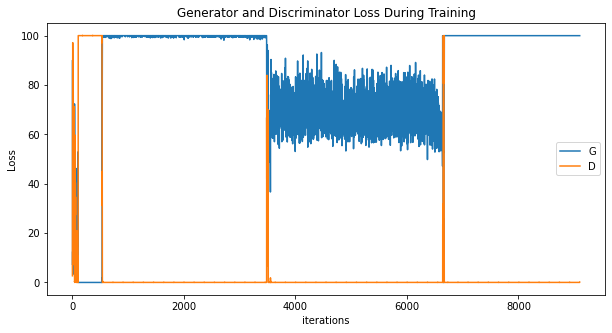

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

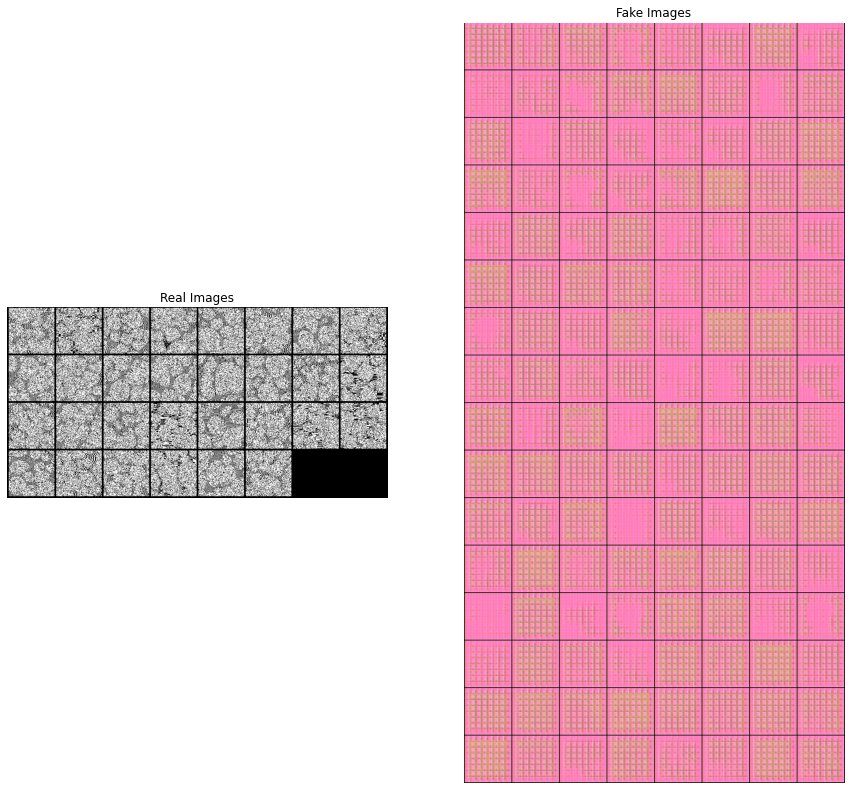

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

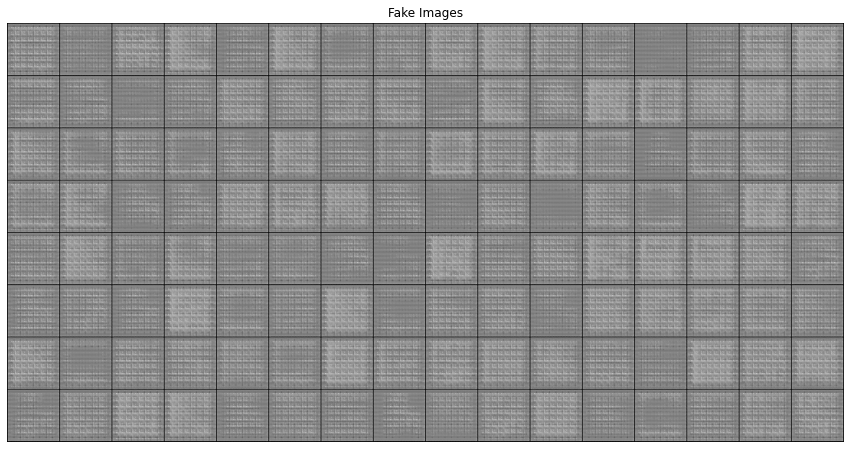

In [71]:
plt.figure(figsize=(15,30))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][1]), cmap=plt.get_cmap('gray'))